In [119]:
import pandas as pd
import psycopg2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
import pickle




In [121]:
db_config = {
    "host": "localhost",
    "database": "my_database",
    "user": "yohannes",
    "password": "yohannes6460",
    "port": 5432
}

try:
    connection = psycopg2.connect(**db_config)
    print("Connected to PostgreSQL database!")
    connection.close()
except Exception as e:
    print(f"Connection failed: {e}")

Connected to PostgreSQL database!


In [122]:

try:
    connection = psycopg2.connect(**db_config)
    cursor = connection.cursor()
    print("Connected to the database.")

    # SQL query to extract data
    query = "SELECT * FROM public.xdr_data"
    cursor.execute(query)

    # Fetch all rows
    rows = cursor.fetchall()

    # Column names
    column_names = [desc[0] for desc in cursor.description]

    # Write to CSV
    output_file = "../src/data/xdr_data_export.csv"
    with open(output_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(column_names)  # Write headers
        writer.writerows(rows)  # Write data rows
        print(f"Data has been exported to {output_file}.")

except Exception as error:
    print(f"Error: {error}")
finally:
    if connection:
        cursor.close()
        connection.close()
        print("Database connection closed.")

Connected to the database.
Data has been exported to ../src/data/xdr_data_export.csv.
Database connection closed.


In [124]:
df = pd.read_csv('../src/data/xdr_data_export.csv')
numeric_columns = [
    'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 
    'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 
    'TCP UL Retrans. Vol (Bytes)', 'DL TP < 50 Kbps (%)',
    'Total UL (Bytes)', 'Total DL (Bytes)'
]
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
date_columns = ['Start', 'End']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

print(df.dtypes)
# Fill missing values with the mean for each column
df.fillna(df.mean() if (type(df) is float or type(df) is int) else 0, inplace=True)

# Verify that missing values have been handled
df.isnull().sum()


Bearer Id                                          float64
Start                                       datetime64[ns]
Start ms                                           float64
End                                         datetime64[ns]
End ms                                             float64
Dur. (ms)                                          float64
IMSI                                               float64
MSISDN/Number                                      float64
IMEI                                               float64
Last Location Name                                  object
Avg RTT DL (ms)                                    float64
Avg RTT UL (ms)                                    float64
Avg Bearer TP DL (kbps)                            float64
Avg Bearer TP UL (kbps)                            float64
TCP DL Retrans. Vol (Bytes)                        float64
TCP UL Retrans. Vol (Bytes)                        float64
DL TP < 50 Kbps (%)                                float

C:\Users\Home\AppData\Local\Temp\ipykernel_21724\4203871182.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.fillna(df.mean() if (type(df) is float or type(df) is int) else 0, inplace=True)


Bearer Id                                   0
Start                                       0
Start ms                                    0
End                                         0
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Last Location Name                          0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
10 Kbps < UL TP < 50 Kbps (%)     

In [125]:

# Calculate Z-scores
z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))

# Find rows with Z-scores greater than 3 (outliers)
outliers = (z_scores > 3).all(axis=1)

# Remove outliers
df_clean = df[~outliers]


In [126]:
# Identify top 10 handsets used by customers
top_handsets = df['Handset Type'].value_counts().head(10)
print(top_handsets)
cleaned_df = df
# Assuming cleaned_data is already defined

# Save cleaned_data to a file
with open("cleaned_df.pkl", "wb") as file:
    pickle.dump(cleaned_df, file)

Handset Type
Huawei B528S-23A                19752
Apple iPhone 6S (A1688)          9419
Apple iPhone 6 (A1586)           9023
undefined                        8987
Apple iPhone 7 (A1778)           6326
Apple iPhone Se (A1723)          5187
Apple iPhone 8 (A1905)           4993
Apple iPhone Xr (A2105)          4568
Samsung Galaxy S8 (Sm-G950F)     4520
Apple iPhone X (A1901)           3813
Name: count, dtype: int64


In [127]:
# Identify top 3 handset manufacturers
top_manufacturers = df['Handset Manufacturer'].value_counts().head(3)
print(top_manufacturers)


Handset Manufacturer
Apple      59565
Samsung    40839
Huawei     34423
Name: count, dtype: int64


In [128]:
# Filter data for top 3 manufacturers
top_3_manufacturers = top_manufacturers.index
filtered_data = df[df['Handset Manufacturer'].isin(top_3_manufacturers)]

# Find the top 5 handsets for each manufacturer
top_5_handsets_per_manufacturer = filtered_data.groupby('Handset Manufacturer')['Handset Type'].value_counts().groupby(level=0).head(5)
print(top_5_handsets_per_manufacturer)
df.head()


Handset Manufacturer  Handset Type                  
Apple                 Apple iPhone 6S (A1688)            9419
                      Apple iPhone 6 (A1586)             9023
                      Apple iPhone 7 (A1778)             6326
                      Apple iPhone Se (A1723)            5187
                      Apple iPhone 8 (A1905)             4993
Huawei                Huawei B528S-23A                  19752
                      Huawei E5180                       2079
                      Huawei P20 Lite Huawei Nova 3E     2021
                      Huawei P20                         1480
                      Huawei Y6 2018                      997
Samsung               Samsung Galaxy S8 (Sm-G950F)       4520
                      Samsung Galaxy A5 Sm-A520F         3724
                      Samsung Galaxy J5 (Sm-J530)        3696
                      Samsung Galaxy J3 (Sm-J330)        3484
                      Samsung Galaxy S7 (Sm-G930X)       3199
Name: count, dtyp

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,2019-04-04 12:01:00,770.0,2019-04-25 14:35:00,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,2019-04-09 13:04:00,235.0,2019-04-25 08:15:00,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,2019-04-09 17:42:00,1.0,2019-04-25 11:58:00,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,2019-04-10 00:31:00,486.0,2019-04-25 07:36:00,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,2019-04-12 20:10:00,565.0,2019-04-25 10:40:00,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [129]:
# Aggregate per user
user_behavior = df.groupby('IMSI').agg({
    'Bearer Id': 'count',                     # Number of xDR sessions
    'Dur. (ms)': 'sum',                      # Total duration
    'Social Media DL (Bytes)': 'sum',        # Social media download
    'Social Media UL (Bytes)': 'sum',        # Social media upload
    'Youtube DL (Bytes)': 'sum',             # YouTube download
    'Youtube UL (Bytes)': 'sum',             # YouTube upload
    'Netflix DL (Bytes)': 'sum',             # Netflix download
    'Netflix UL (Bytes)': 'sum',             # Netflix upload
    'Google DL (Bytes)': 'sum',              # Google download
    'Google UL (Bytes)': 'sum',              # Google upload
    'Email DL (Bytes)': 'sum',               # Email download
    'Email UL (Bytes)': 'sum',               # Email upload
    'Gaming DL (Bytes)': 'sum',              # Gaming download
    'Gaming UL (Bytes)': 'sum',              # Gaming upload,
    'Other DL (Bytes)': 'sum',                       # Other download
    'Other UL (Bytes)': 'sum'                        # Other upload
})

# Calculate total data volume (DL + UL) for each application
user_behavior['Total Social Media'] = user_behavior['Social Media DL (Bytes)'] + user_behavior['Social Media UL (Bytes)']
user_behavior['Total YouTube'] = user_behavior['Youtube DL (Bytes)'] + user_behavior['Youtube UL (Bytes)']
user_behavior['Total Netflix'] = user_behavior['Netflix DL (Bytes)'] + user_behavior['Netflix UL (Bytes)']
user_behavior['Total Google'] = user_behavior['Google DL (Bytes)'] + user_behavior['Google UL (Bytes)']
user_behavior['Total Email'] = user_behavior['Email DL (Bytes)'] + user_behavior['Email UL (Bytes)']
user_behavior['Total Gaming'] = user_behavior['Gaming DL (Bytes)'] + user_behavior['Gaming UL (Bytes)']
user_behavior['Total Other'] = user_behavior['Other DL (Bytes)'] + user_behavior['Other UL (Bytes)']

# Display the aggregated data
user_behavior.head()


,Bearer Id,Dur. (ms),Social Media DL (Bytes),Social Media UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Google DL (Bytes),Google UL (Bytes),...,Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total Social Media,Total YouTube,Total Netflix,Total Google,Total Email,Total Gaming,Total Other
IMSI,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,570,37507441.0,1.033955e+09,1.928896e+07,6.851450e+09,6.232417e+09,6.732883e+09,6.395985e+09,3.203299e+09,1.181741e+09,...,4.565405e+09,2.341575e+11,4.889854e+09,1.053244e+09,1.308387e+10,1.312887e+10,4.385040e+09,1.300748e+09,2.441764e+11,2.390474e+11
2.040471e+14,1,869844.0,1.500145e+06,4.594300e+04,1.898032e+07,2.196039e+07,2.162134e+07,7.224894e+06,5.985089e+06,3.233558e+06,...,1.497798e+07,3.891597e+08,1.220074e+07,1.546088e+06,4.094071e+07,2.884623e+07,9.218647e+06,3.330974e+06,4.307026e+07,4.013605e+08
2.040808e+14,1,877385.0,6.685960e+05,4.662800e+04,9.839889e+06,2.120016e+06,1.034091e+07,1.625139e+07,8.572779e+06,1.865881e+06,...,1.348513e+07,4.676781e+08,2.848373e+06,7.152240e+05,1.195990e+07,2.659230e+07,1.043866e+07,1.520771e+06,1.780487e+08,4.705265e+08
2.082001e+14,1,86019.0,3.073697e+06,4.908400e+04,5.556563e+06,1.432588e+07,1.530536e+07,1.652520e+07,6.036910e+05,1.020971e+06,...,5.363582e+06,5.000445e+08,1.592918e+07,3.122781e+06,1.988244e+07,3.183056e+07,1.624662e+06,3.657501e+06,9.124516e+06,5.159737e+08
2.082001e+14,1,86254.0,2.542767e+06,3.433700e+04,2.241471e+07,3.242918e+06,1.006564e+07,1.772021e+07,1.069983e+07,3.111651e+06,...,1.593940e+05,3.009029e+08,8.707888e+06,2.577104e+06,2.565763e+07,2.778585e+07,1.381148e+07,3.855734e+06,3.441059e+08,3.096107e+08


In [111]:
# Replace missing values with column mean
user_behavior.fillna(user_behavior.mean(), inplace=True)

# Handle outliers using the IQR method
Q1 = user_behavior.quantile(0.25)
Q3 = user_behavior.quantile(0.75)
IQR = Q3 - Q1

# Remove outliers (values outside 1.5 * IQR range)
user_behavior = user_behavior[~((user_behavior < (Q1 - 1.5 * IQR)) | (user_behavior > (Q3 + 1.5 * IQR))).any(axis=1)]

# Verify the cleaned data
user_behavior.describe()


,Bearer Id,Dur. (ms),Social Media DL (Bytes),Social Media UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Google DL (Bytes),Google UL (Bytes),...,Other DL (Bytes),Other UL (Bytes),Total Social Media,Total YouTube,Total Netflix,Total Google,Total Email,Total Gaming,Total Other,Duration Decile
count,89144.000000,89144.000000,8.914400e+04,89144.000000,8.914400e+04,8.914400e+04,8.914400e+04,8.914400e+04,8.914400e+04,8.914400e+04,...,8.914400e+04,8.914400e+04,8.914400e+04,8.914400e+04,8.914400e+04,8.914400e+04,8.914400e+04,8.914400e+04,8.914400e+04,89144.000000
mean,1.136330,106525.107197,2.031146e+06,37223.796453,1.307542e+07,1.239184e+07,1.307968e+07,1.238462e+07,6.473643e+06,2.320563e+06,...,4.758976e+08,9.343076e+06,2.068370e+06,2.546726e+07,2.546430e+07,8.794205e+06,2.544285e+06,4.869602e+08,4.852406e+08,3.867888
std,0.343304,65112.222034,1.243143e+06,22868.364732,7.933498e+06,7.498869e+06,7.971899e+06,7.535110e+06,3.908428e+06,1.420307e+06,...,2.910751e+08,5.703941e+06,1.248549e+06,1.195723e+07,1.203570e+07,4.428488e+06,1.328752e+06,2.924365e+08,2.923901e+08,2.583632
min,1.000000,7142.000000,1.200000e+01,0.000000,5.300000e+01,1.060000e+02,4.200000e+01,3.500000e+01,2.070000e+02,3.000000e+00,...,3.290000e+03,1.560000e+02,1.563000e+03,7.890300e+04,1.845690e+05,4.033000e+04,1.817600e+04,3.063580e+05,1.490450e+05,0.000000
25%,1.000000,58266.750000,1.016841e+06,18601.750000,6.608944e+06,6.240426e+06,6.507701e+06,6.203830e+06,3.288468e+06,1.154484e+06,...,2.387149e+08,4.704077e+06,1.050543e+06,1.714058e+07,1.708067e+07,5.367496e+06,1.490563e+06,2.487346e+08,2.472800e+08,2.000000
50%,1.000000,88890.500000,1.991060e+06,36464.000000,1.284268e+07,1.220729e+07,1.287858e+07,1.220027e+07,6.368564e+06,2.276101e+06,...,4.655962e+08,9.149744e+06,2.024659e+06,2.431967e+07,2.426755e+07,8.565838e+06,2.490478e+06,4.783744e+08,4.749316e+08,4.000000
75%,1.000000,148461.000000,2.930562e+06,53643.000000,1.890226e+07,1.792319e+07,1.894468e+07,1.788249e+07,9.344493e+06,3.353548e+06,...,6.857084e+08,1.345816e+07,2.966578e+06,3.242560e+07,3.239927e+07,1.159571e+07,3.431570e+06,6.975340e+08,6.950948e+08,6.000000
max,3.000000,326277.000000,6.395829e+06,117346.000000,4.133537e+07,3.904604e+07,4.142194e+07,3.920074e+07,2.036347e+07,7.345618e+06,...,1.495096e+09,2.936763e+07,6.447970e+06,6.681954e+07,6.697679e+07,2.410723e+07,7.102809e+06,1.509552e+09,1.509420e+09,9.000000


In [112]:
# Add a column for total session duration in seconds
user_behavior['Total Duration (s)'] = user_behavior['Dur. (ms)'] / 1000

# Create decile segmentation
user_behavior['Decile'] = pd.qcut(user_behavior['Total Duration (s)'], 10, labels=False)

# Calculate total data usage (DL + UL) for each decile
decile_analysis = user_behavior.groupby('Decile').agg({
    'Total Social Media': 'mean',
    'Total YouTube': 'mean',
    'Total Netflix': 'mean',
    'Total Google': 'mean',
    'Total Email': 'mean',
    'Total Gaming': 'mean',
    'Total Other': 'mean'
})

# Display the segmentation results
decile_analysis


C:\Users\Home\AppData\Local\Temp\ipykernel_21724\2573252251.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_behavior['Total Duration (s)'] = user_behavior['Dur. (ms)'] / 1000
C:\Users\Home\AppData\Local\Temp\ipykernel_21724\2573252251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_behavior['Decile'] = pd.qcut(user_behavior['Total Duration (s)'], 10, labels=False)


,Total Social Media,Total YouTube,Total Netflix,Total Google,Total Email,Total Gaming,Total Other
Decile,,,,,,,
0,1.850550e+06,2.283205e+07,2.299509e+07,7.852087e+06,2.291706e+06,4.350880e+08,4.326657e+08
1,1.971518e+06,2.421934e+07,2.431760e+07,8.356279e+06,2.418881e+06,4.627233e+08,4.559031e+08
2,2.128428e+06,2.611171e+07,2.619671e+07,9.070301e+06,2.601979e+06,5.006513e+08,4.974412e+08
3,1.874647e+06,2.341079e+07,2.325649e+07,8.056135e+06,2.319962e+06,4.442065e+08,4.453913e+08
4,1.898150e+06,2.311957e+07,2.307626e+07,7.929616e+06,2.311133e+06,4.384986e+08,4.451031e+08
5,1.958095e+06,2.421210e+07,2.449146e+07,8.448373e+06,2.432287e+06,4.687409e+08,4.670265e+08
6,2.065127e+06,2.544073e+07,2.531304e+07,8.747876e+06,2.543054e+06,4.841929e+08,4.873529e+08
7,1.972868e+06,2.440657e+07,2.408374e+07,8.350898e+06,2.417599e+06,4.652709e+08,4.581681e+08
8,2.410679e+06,2.940576e+07,2.946497e+07,1.023740e+07,2.958860e+06,5.634807e+08,5.632207e+08


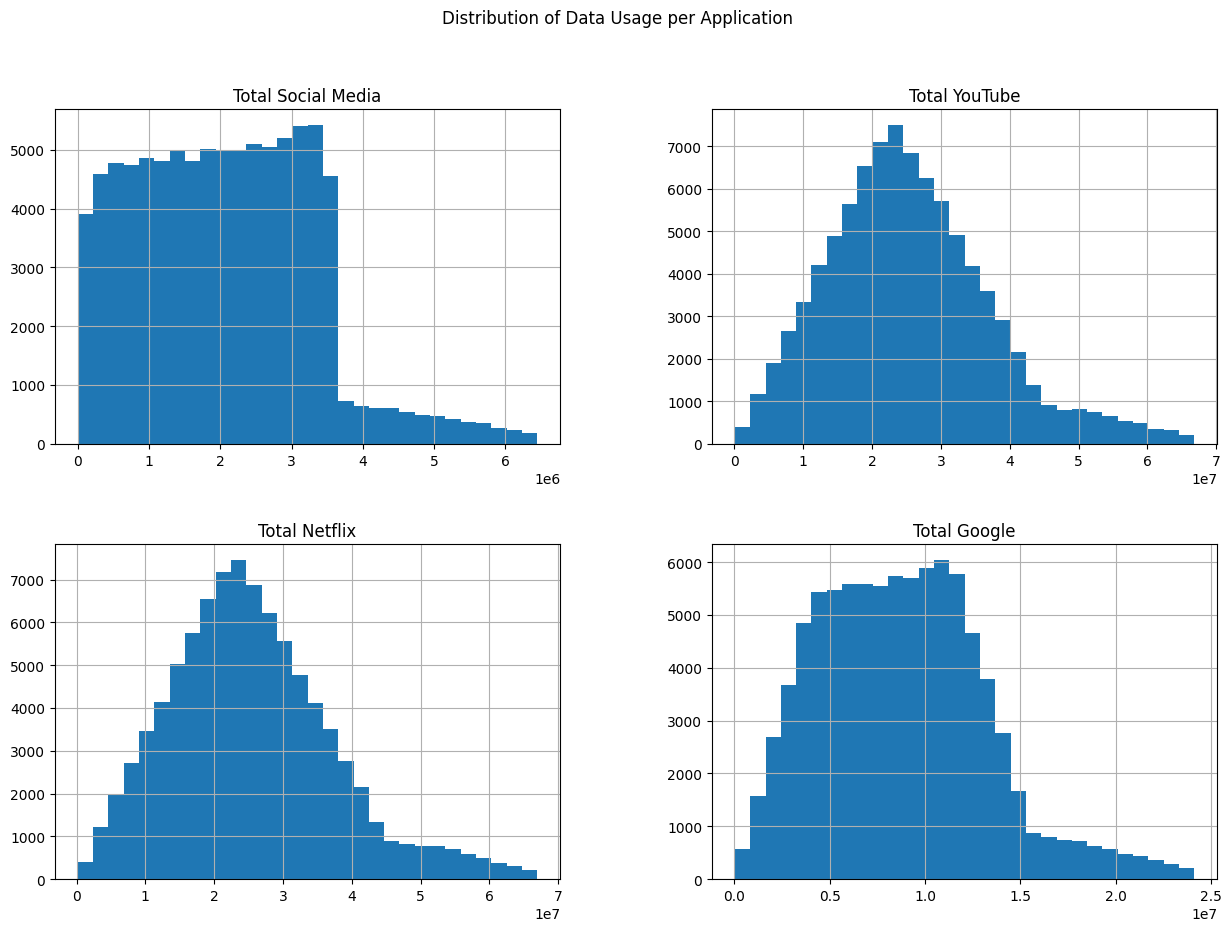

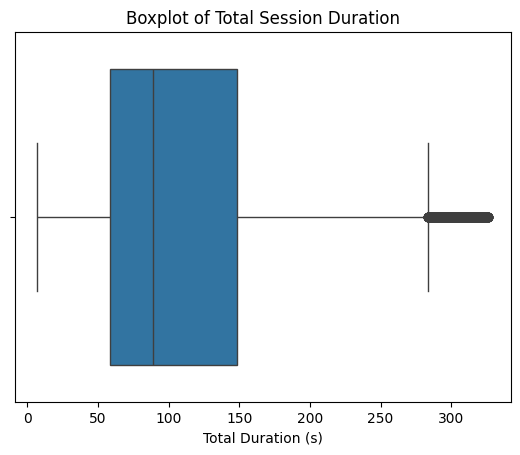

In [113]:


# Plot histograms for total data usage per application
user_behavior[['Total Social Media', 'Total YouTube', 'Total Netflix', 'Total Google']].hist(bins=30, figsize=(15, 10))
plt.suptitle("Distribution of Data Usage per Application")
plt.show()

# Boxplot for session durations
sns.boxplot(x=user_behavior['Total Duration (s)'])
plt.title("Boxplot of Total Session Duration")
plt.show()


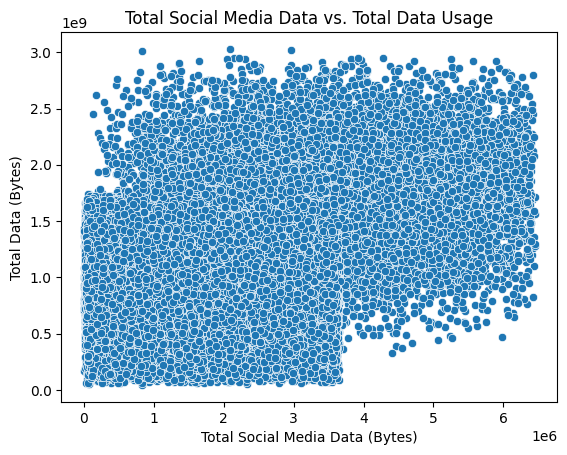

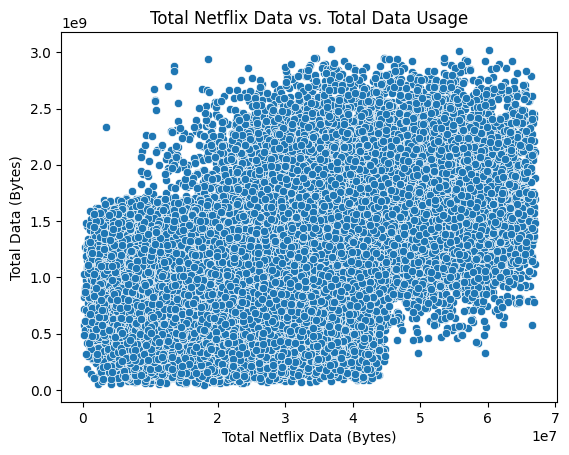

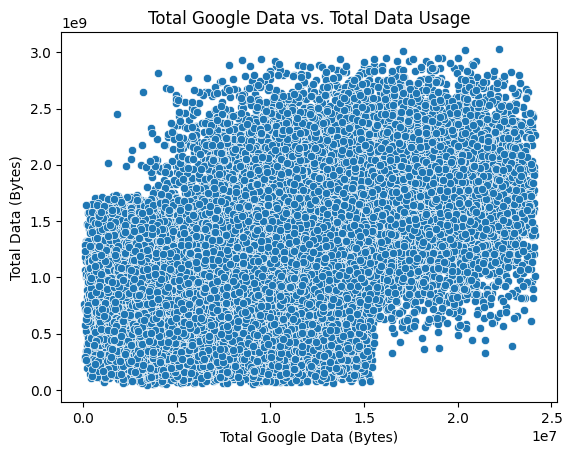

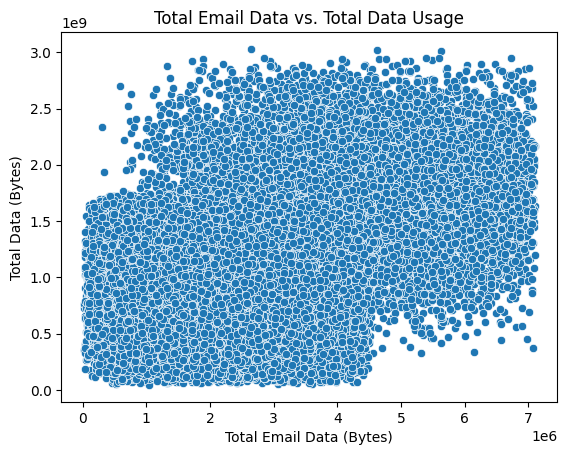

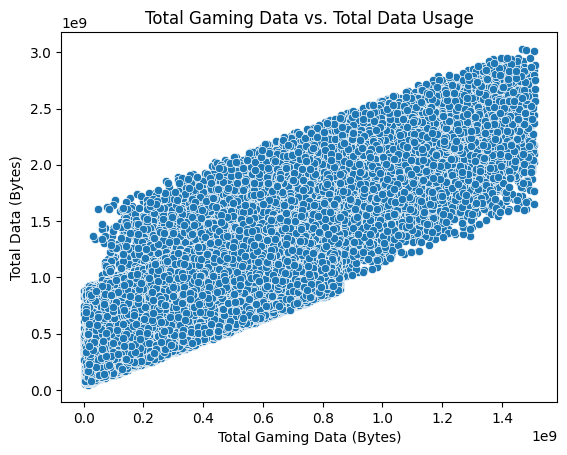

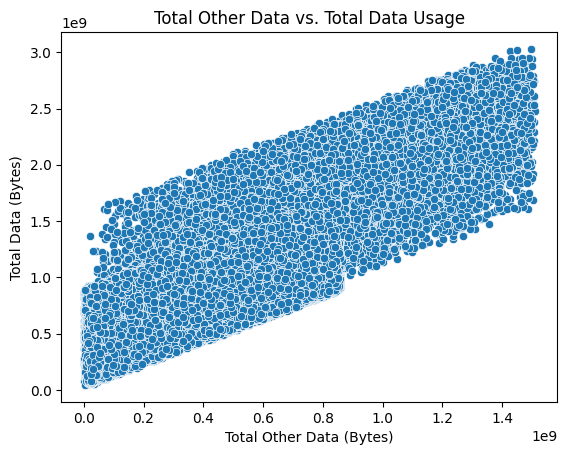

In [117]:
# List of applications to analyze
applications = [
    'Total Social Media', 
    'Total Netflix', 
    'Total Google', 
    'Total Email', 
    'Total Gaming', 
    'Total Other'
]

# Generate scatter plots
for app in applications:
    sns.scatterplot(x=user_behavior[app], y=user_behavior[applications].sum(axis=1))
    plt.title(f"{app} Data vs. Total Data Usage")
    plt.xlabel(f"{app} Data (Bytes)")
    plt.ylabel("Total Data (Bytes)")
    plt.show()


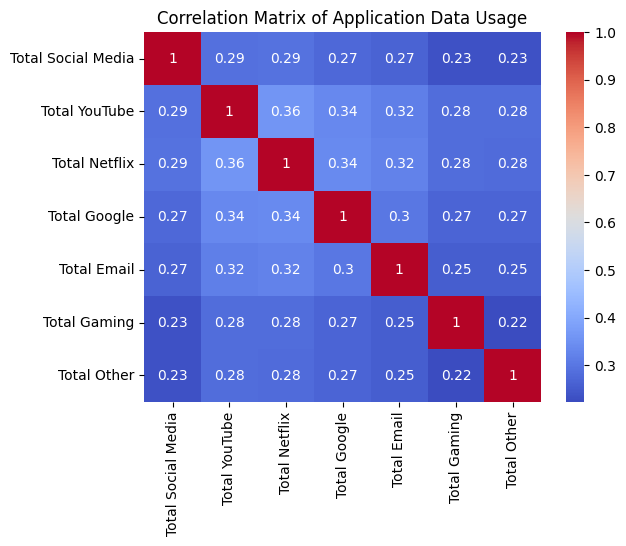

In [118]:
# Select relevant columns for correlation analysis
data_columns = ['Total Social Media', 'Total YouTube', 'Total Netflix', 'Total Google', 'Total Email', 'Total Gaming', 'Total Other']

# Compute correlation matrix
correlation_matrix = user_behavior[data_columns].corr()

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Application Data Usage")
plt.show()


Explained Variance Ratios: [0.38680822 0.11102638]


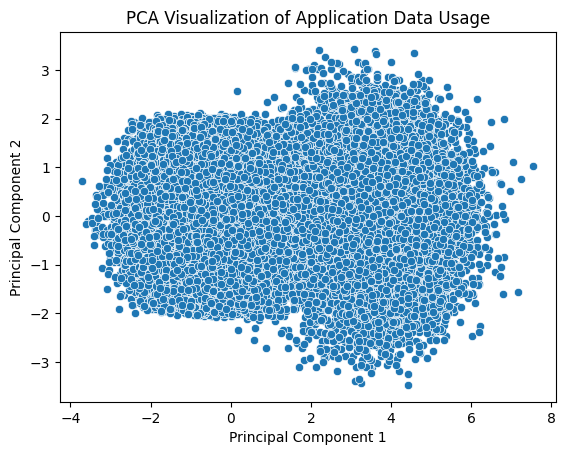

In [116]:


# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(user_behavior[data_columns])

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance Ratios: {explained_variance}")

# Visualize the PCA result
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1])
plt.title("PCA Visualization of Application Data Usage")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()
